In [3]:
%load_ext autoreload
%autoreload 2

# Multislice Simulations

A step forward through a slice of the potential consists of a transmission and a propagation.

In [30]:
from abtem.potentials import PrecalculatedPotential
from abtem.waves import PlaneWaves
import numpy as np

potential = PrecalculatedPotential.read('srtio3_110_potential.hdf5')
plane_wave = PlaneWaves(energy=300e3)

In [ ]:
potential.to

The `Wave` objects can be transmitted through a potential slice, which in the weak-phase approximation is just a phase shift. To complete a forward step the transmitted wave is propagated be some distance along the toptical axis. 
We demonstrate a single step below, the plane wave is transmitted through the eleventh slice and then propagated by the slice thickness.

(<matplotlib.axes._subplots.AxesSubplot at 0x1748672dd08>,
 <matplotlib.image.AxesImage at 0x1748c02f608>)

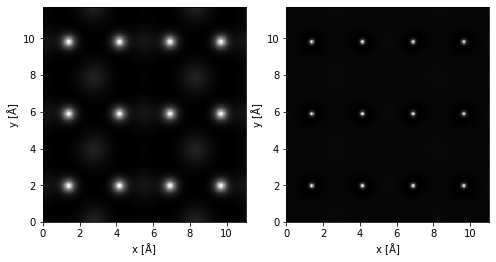

In [28]:
import matplotlib.pyplot as plt

transmitted = plane_wave.transmit(potential[9])
propagated = transmitted.propagate(potential[9].thickness, in_place=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
transmitted.plot(ax=ax1, complex_representation='phase')
propagated.plot(ax=ax2, complex_representation='abs2')

The complete multislice algorithm just repeats this for all slices sequentially, hence it can just be implemented as a loop.

(<matplotlib.axes._subplots.AxesSubplot at 0x1748be2b1c8>,
 <matplotlib.image.AxesImage at 0x174861a2808>)

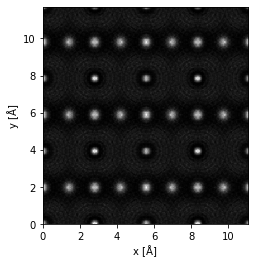

In [26]:
wave = PlaneWaves(energy=300e3)

for potential_slice in potential:
    wave = wave.transmit(potential_slice)
    wave = wave.propagate(potential_slice.thickness)
    
wave.plot()

In practice 

## Planewave multislice simulation

Using what we learned in the previous tutorials, it is straightforward to perform a multislice calculation with plane waves. Here we use the atomic model, we exported in an earlier tutorials.

In [1]:
from abtem.potentials import Potential
from abtem.waves import PlaneWaves
from ase.io import read

atoms = read('srtio3_110.cif')

wave = PlaneWaves(sampling=.05, energy=300e3)

potential = Potential(atoms)

exit_wave = wave.multislice(potential, show_progress=False)

We can plot the exit wave function using the `plot_image` function. Here we choose to show the phase.

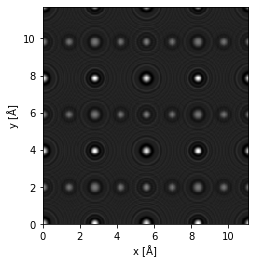

In [6]:
exit_wave.plot() 

The exit wave function is exported for use in the next tutorial.

In [3]:
exit_wave.write('srtio3_exit_wave.npz')

## Compatible grids

You may have noted that the extent of the wave function was not given in the above, nor was the sampling of the potential. Since the potential have an extent, from the cell of the atoms, and the sampling is defined for the wave function, there is enough information to infer the grid, before starting the multislice propagation. On the other hand, the following will result in a runtime error because the sampling cannot be inferred from the information given.

In [5]:
wave = PlaneWaves(energy=300e3)
potential = Potential(atoms)
exit_wave = wave.multislice(potential)

The next bit of code will also result in an error because the sampling of the wave function and the potential is different.

In [ ]:
wave = PlaneWaves(sampling=.1, energy=300e3)
potential = Potential(sampling=.05, atoms)
exit_wave = wave.multislice(potential)

## Probe wave function multislice simulation

It is possible to propagate the a probe wave function at a specific position. This may be useful for simlating Convergent Beam Electron Diffraction (CBED) patterns.

In [7]:
from abtem.waves import ProbeWaves

probe = ProbeWaves(sampling=.05, extent=potential.extent, energy=200e3, semiangle_cutoff=.02)

exit_wave = probe.build_at((3.3, 4)).multislice(potential, show_progress=False)

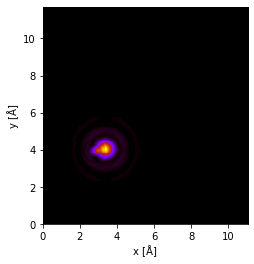

In [8]:
exit_wave.plot(cmap='gnuplot')

The square modulus of the Fourier transform of a function is called its power spectra. The power spectra of the wave function transmitted through the specimen is also equivalent to the electron diffraction pattern of the specimen. numpy can be used for calculate the power spectra of a wave function.

In [114]:
import numpy as np
diffraction_pattern = np.abs(np.fft.fftshift(np.fft.fft2(exit_wave.array))) ** 2

In [11]:
list(range(-2,0))

[-2, -1]

The `plot_image` function can be used for displaying diffraction patterns by setting `space='fourier'`. A diffraction pattern typically has a very large dynamic range in its intensity. The low spatial frequency information (low scattering angle) has a large amplitude but the high spatial frequency information (high scattering angle) has a much lower amplitude. The high spatial frequency information (which is frequently the interesting part) is not visible if the diffraction pattern is normalized to fill the available grey scale in a linear manner. It is to common to transform the intensities as:

$$
\log(1 + c |F(k_x,k_y)|^2) \quad ,
$$

where $F(k_x, k_y)$ is the Fourier transform of the image and the constant $c$ can be varied to adjust the contrast.

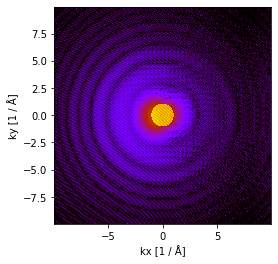

In [121]:
plot_image(exit_wave, space='fourier', scale='log', logscale_constant=.1, cmap='gnuplot')